In [1]:
import wrangle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches


# pd.reset_option('display.max_rows')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Running the function from the `wrangle.py` module to acquire and prepare data for explore

In [2]:
df = wrangle.get_curriculum_logs_data()

The df has 847330 rows and 10 columns.


#### Looking at the null counts...

In [3]:
df.isna().sum()

cohortid        0
start_date      0
end_date        0
cohortname      0
program_id      0
date            0
time            0
path            1
user_id         0
ip              0
program_name    0
is_staff        0
dtype: int64

In [4]:
# dropping the x1 null value
df.dropna(inplace = True)

# confirming no nulls left
df.isna().sum().sum()

0

### Questions to Explore...
- Q1: Which lesson appears to attract the most traffic consistently across cohorts (per program)?
- Q2: Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?
- Q7: Which lessons are least accessed?
<hr>
- Q5: At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?
- Q8: Anything else I should be aware of?

## Q1: Which lesson appears to attract the most traffic consistently across cohorts (per program)?
In order to answer this question I will start by exploring the values in the `path` column.

In [5]:
# value counts of each unique path
df.path.value_counts()

/                                                                                                                                                                                                                                                                                                                         45854
javascript-i                                                                                                                                                                                                                                                                                                              18203
toc                                                                                                                                                                                                                                                                                                                       17591
search/search_index.json                

### I want to simplify the `path` values to get a better idea of the lessons.
The first part (before the `/` mark is where I will start. I will split these values and create a new column called `main_path`
- If there is time after, I may come back and add a `sub_path` column with the second part of the `path` values after the `/` mark and look at those values as well

In [6]:
# creating new column with the first part of the path, before the / mark
df['main_path'] = df.path.str.split('/').str[0]
df.head(10)

cohortid start_date   end_date cohortname  program_id       date      time  \
0         1 2014-02-04 2014-04-22     Arches           1 2018-01-26  10:14:47   
1         1 2014-02-04 2014-04-22     Arches           1 2018-01-26  10:14:51   
2         1 2014-02-04 2014-04-22     Arches           1 2018-01-26  10:15:02   
3         1 2014-02-04 2014-04-22     Arches           1 2018-01-26  11:46:29   
4         1 2014-02-04 2014-04-22     Arches           1 2018-01-26  11:46:39   
5         1 2014-02-04 2014-04-22     Arches           1 2018-01-26  11:46:47   
6         1 2014-02-04 2014-04-22     Arches           1 2018-01-26  11:47:01   
7         1 2014-02-04 2014-04-22     Arches           1 2018-01-26  11:47:03   
8         1 2014-02-04 2014-04-22     Arches           1 2018-01-26  11:47:05   
9         1 2014-02-04 2014-04-22     Arches           1 2018-01-26  12:10:30   

                                                path  user_id            ip  \
0                                                  /       11  97.105.19.61   
1                                       javascript-i       11  97.105.19.61   
2                             javascript-i/functions       11  97.105.19.61   
3  appendix/further-reading/javascript/hoisting.html       11  97.105.19.61   
4                                           appendix       11  97.105.19.61   
5       appendix/further-reading/javascript/hoisting       11  97.105.19.61   
6                         appendix/capstone-workbook       11  97.105.19.61   
7                                       javascript-i       11  97.105.19.61   
8                             javascript-i/functions       11  97.105.19.61   
9                          javascript-i/conditionals       11  97.105.19.61   

  program_name  is_staff     main_path  
0      web_dev     False                
1      web_dev     False  javascript-i  
2      web_dev     False  javascript-i  
3      web_dev     False      appendix  
4      web_dev     False      appendix  
5      web_dev     False      appendix  
6      web_dev     False      appendix  
7      web_dev     False  javascript-i  
8      web_dev     False  javascript-i  
9      web_dev     False  javascript-i

#### There are some empty values for `main_path` and I want to see what those are.. I will filter the df and look

In [7]:
# filtering to path values for paths beginning with empty string
df[df.main_path == ''].path.value_counts()

/    45854
Name: path, dtype: int64

#### These can be filtered out since they are all just the strings

In [8]:
df2 = df[df.main_path != '']
df2.head()

cohortid start_date   end_date cohortname  program_id       date      time  \
1         1 2014-02-04 2014-04-22     Arches           1 2018-01-26  10:14:51   
2         1 2014-02-04 2014-04-22     Arches           1 2018-01-26  10:15:02   
3         1 2014-02-04 2014-04-22     Arches           1 2018-01-26  11:46:29   
4         1 2014-02-04 2014-04-22     Arches           1 2018-01-26  11:46:39   
5         1 2014-02-04 2014-04-22     Arches           1 2018-01-26  11:46:47   

                                                path  user_id            ip  \
1                                       javascript-i       11  97.105.19.61   
2                             javascript-i/functions       11  97.105.19.61   
3  appendix/further-reading/javascript/hoisting.html       11  97.105.19.61   
4                                           appendix       11  97.105.19.61   
5       appendix/further-reading/javascript/hoisting       11  97.105.19.61   

  program_name  is_staff     main_path  
1      web_dev     False  javascript-i  
2      web_dev     False  javascript-i  
3      web_dev     False      appendix  
4      web_dev     False      appendix  
5      web_dev     False      appendix

This gives me a pretty good idea of the lessons from each log.
#### Now I want to be able to look at `path` values across `program_name` . . .

In [9]:
# looking at the path value_counts by cohorts, starting with web_dev
df2[(df2.program_name == 'web_dev')].path.value_counts().head(10)

javascript-i                18193
toc                         17580
search/search_index.json    15331
java-iii                    13162
html-css                    13111
java-ii                     12173
spring                      11877
jquery                      11037
mysql                       10602
java-i                      10460
Name: path, dtype: int64

In [10]:
# the values and value_counts() for the top 10 data_science paths
df2[(df2.program_name == 'data_science')].path.value_counts().head(10)

search/search_index.json                    2203
classification/overview                     1785
1-fundamentals/modern-data-scientist.jpg    1655
1-fundamentals/AI-ML-DL-timeline.jpg        1651
1-fundamentals/1.1-intro-to-data-science    1633
classification/scale_features_or_not.svg    1590
fundamentals/AI-ML-DL-timeline.jpg          1443
fundamentals/modern-data-scientist.jpg      1438
sql/mysql-overview                          1424
fundamentals/intro-to-data-science          1413
Name: path, dtype: int64

### Now to visualize...

In [11]:
# looking at unique program_names
df2.program_name.unique()

array(['web_dev', 'data_science'], dtype=object)

## First I will look at the breakdown by `main_path` and then by `path`

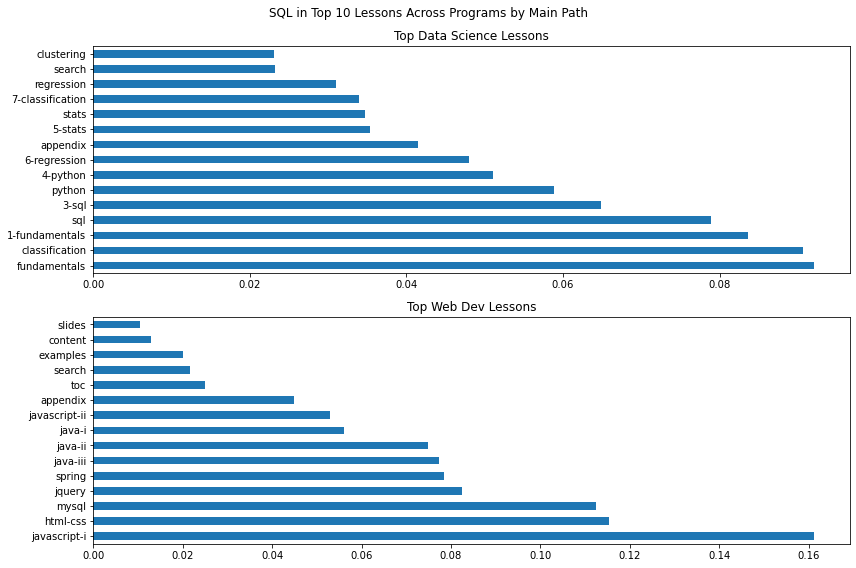

In [12]:
# setting figure size
plt.figure(figsize = (12, 8))

# subplot 1 (top) data science lessons
plt.subplot(2, 1, 1)
df2[(df2.program_name == 'data_science')].main_path.value_counts(sorted).head(15).plot.barh()
plt.title('Top Data Science Lessons')

# subplot 2 (bottom) web dev lesson
plt.subplot(2, 1, 2)
df2[(df2.program_name == 'web_dev')].main_path.value_counts(sorted).head(15).plot.barh()
plt.title('Top Web Dev Lessons')

# figure title
plt.suptitle('SQL in Top 10 Lessons Across Programs by Main Path')
plt.tight_layout()
plt.show();


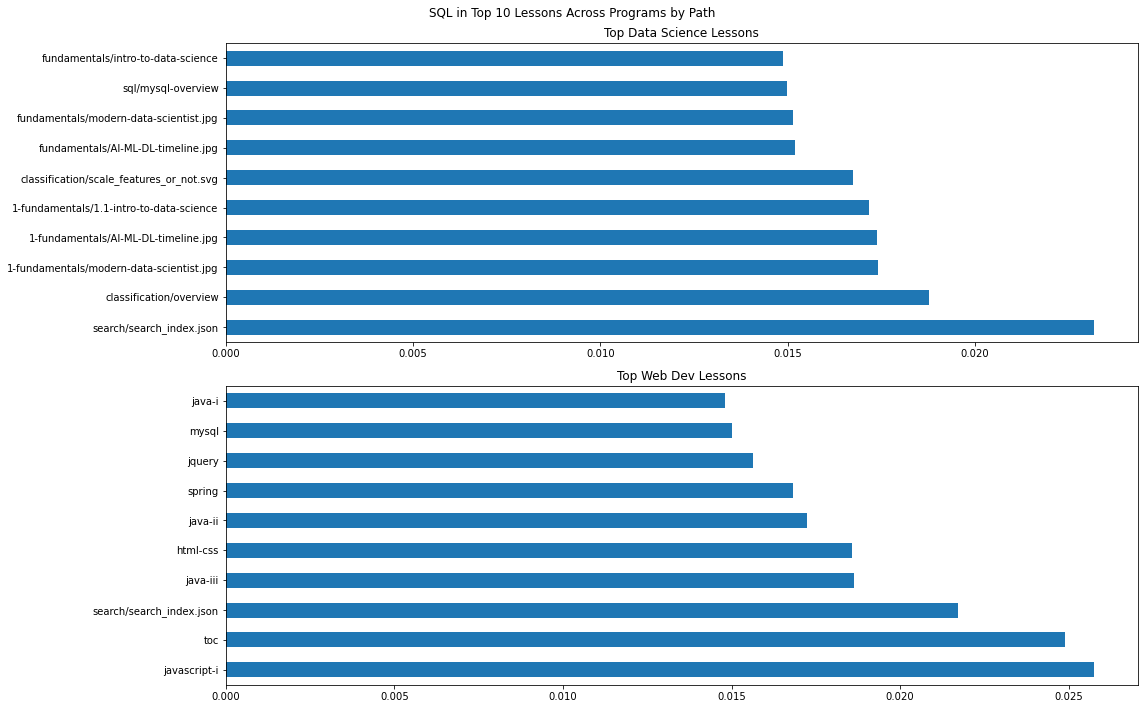

In [13]:
# setting figure size
plt.figure(figsize = (16, 10))

# subplot 1 (top) data science lessons
plt.subplot(2, 1, 1)
df2[(df2.program_name == 'data_science')].path.value_counts(sorted).head(10).plot.barh()
plt.title('Top Data Science Lessons')

# subplot 2 (bottom) web dev lesson
plt.subplot(2, 1, 2)
df2[(df2.program_name == 'web_dev')].path.value_counts(sorted).head(10).plot.barh()
plt.title('Top Web Dev Lessons')

# figure title
plt.suptitle('SQL in Top 10 Lessons Across Programs by Path')
plt.tight_layout()
plt.show();

>## A1: `SQL` appears in the top 10 paths across both programs.
`SQL`, 8th most acessed lesson across both the `web_dev` and `data_science` programs

## Q2: Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?
To answer this question I will continue looking at the `path` values but will do a groupby with  `cohortname`

In [14]:
paths = df2.groupby(['path', 'cohortname', 'main_path']).count().reset_index()[['path', 'cohortname', 'main_path', 'user_id']].sort_values(by = 'user_id', ascending = False)
paths.rename(columns = {'user_id': 'access_count'}, inplace = True)

In [15]:
paths.head()

path cohortname     main_path  access_count
13288                       toc    Jupiter           toc          1866
8938               javascript-i      Staff  javascript-i          1817
11823  search/search_index.json       Apex        search          1497
13309                       toc       Zion           toc          1465
12425                    spring      Staff        spring          1403

In [16]:
# excluding / path and Staff cohortname
paths = paths[(paths.cohortname != 'Staff')]

In [17]:
paths.head(20)

path cohortname       main_path  \
13288                                       toc    Jupiter             toc   
11823                  search/search_index.json       Apex          search   
13309                                       toc       Zion             toc   
11828                  search/search_index.json      Ceres          search   
13281                                       toc    Fortuna             toc   
3921                    classification/overview     Darden  classification   
11836                  search/search_index.json   Ganymede          search   
13285                                       toc   Hyperion             toc   
11835                  search/search_index.json    Fortuna          search   
8913                               javascript-i      Ceres    javascript-i   
11841                  search/search_index.json    Jupiter          search   
13306                                       toc   Wrangell             toc   
13280                                       toc     Europa             toc   
3948   classification/scale_features_or_not.svg     Darden  classification   
8924                               javascript-i    Jupiter    javascript-i   
13277                                       toc      Ceres             toc   
13294                                       toc      Marco             toc   
8921                               javascript-i   Hyperion    javascript-i   
8930                               javascript-i      Marco    javascript-i   
8945                               javascript-i       Zion    javascript-i   

       access_count  
13288          1866  
11823          1497  
13309          1465  
11828          1380  
13281          1293  
3921           1109  
11836          1095  
13285          1022  
11835          1020  
8913           1003  
11841           998  
13306           991  
13280           964  
3948            943  
8924            926  
13277           911  
13294           910  
8921            910  
8930            907  
8945            897

In [18]:
# concatenating the top and bottom values
pd.concat([paths.head(300), paths.tail(300)]).groupby(['path', 'cohortname']).sum()\
                            .sort_values(by = ['path'])

access_count
path                                               cohortname              
1-fundamentals/1.1-intro-to-data-science           Bayes                640
                                                   Curie                461
                                                   Darden               460
1-fundamentals/AI-ML-DL-timeline.jpg               Bayes                648
                                                   Curie                465
                                                   Darden               470
1-fundamentals/modern-data-scientist.jpg           Bayes                650
                                                   Curie                467
                                                   Darden               470
10-anomaly-detection/1-overview                    Bayes                384
10-anomaly-detection/AnomalyDetectionCartoon.jpeg  Bayes                387
3-sql/1-mysql-overview                             Curie                441
6-regression/1-overview                            Bayes                521
                                                   Curie                595
anomaly-detection/AnomalyDetectionCartoon.jpeg     Darden               612
anomaly-detection/overview                         Darden               592
appendix                                           Voyageurs            394
                                                   Teddy                505
                                                   Jupiter              421
                                                   Hyperion             400
                                                   Apex                 450
                                                   Fortuna              356
                                                   Ceres                411
                                                   Ganymede             561
classification/classical_programming_vs_machine... Easley               432
classification/logistic-regression                 Darden               423
classification/overview                            Darden              1109
                                                   Easley               445
classification/prep                                Darden               367
classification/scale_features_or_not.svg           Darden               943
                                                   Easley               463
content/jquery/ajax/gitbook/images/favicon.ico     Teddy                  1
                                                   Quincy                 1
content/php_i/types-and-variables-i                Sequoia                1
                                                   Voyageurs              1
                                                   Hampton                1
                                                   Joshua                 1
content/php_i/types-and-variables-i/boolean-dat... Andromeda              1
                                                   Joshua                 1
                                                   Pinnacles              1
                                                   Sequoia                1
content/php_i/types-and-variables-i/gitbook/ima... Voyageurs              1
                                                   Quincy                 1
                                                   Sequoia                1
                                                   Ceres                  1
                                                   Hampton                1
content/php_i/types-and-variables-i/intergers-a... Andromeda              1
                                                   Joshua                 1
                                                   Sequoia                1
                                                   Yosemite               1
content/php_i/types-and-variables-i/introductio... Andromeda              1
                                   

### Going to try this another way ... 
- Using groupby `path` and then `cohortname` is giving me what I need to see but the `path` includes subcomponents and is giving me too many results to be able to meaningfully answer this question.
- I am going to `split` the path and use the 2nd part of the path to create a new column called `lesson`

In [19]:
# creating a df with 2 index levels:
#     main level = path
#     2nd level = cohortname
cohort_paths = df2.groupby(['path', 'cohortname']).agg('count')#.reset_index()#[['path', 'cohortname', 'user_id']]
cohort_paths = pd.DataFrame(cohort_paths['cohortid'])#.sort_values(by = [['path', 'cohortname', 'cohortid']])
cohort_paths.head(30)

cohortid
path                                   cohortname          
%20https://github.com/RaulCPena        Curie              1
'                                      Staff              1
,%20https://github.com/RaulCPena       Curie              1
.git                                   Voyageurs          1
.gitignore                             Darden             1
                                       Voyageurs          1
.well-known/assetlinks.json            Hyperion           2
00_                                    Staff              1
00_index                               Staff              7
                                       Wrangell           2
01_intro                               Staff              7
                                       Wrangell           2
02_listing_files                       Staff              9
                                       Wrangell           1
03_file_paths                          Staff             10
                                       Wrangell           1
04_navigating_the_filesystem           Staff             10
                                       Wrangell           1
05_creating_files_and_directories      Staff              9
                                       Wrangell           1
06_moving_files                        Staff              7
07_more_topics                         Staff              7
0_Classification_Algorithms            Arches             1
                                       Hampton            1
1-fundamentals                         Darden            10
1-fundamentals/1-fundamentals-overview Staff             51
                                       Teddy              1
                                       Ulysses            1
                                       Voyageurs          3
                                       Zion               1

In [20]:
# creating another df with 2 index levels:
#     main level = main_path
#     2nd level = cohortname
cohort_main_paths = df2.groupby(['main_path', 'cohortname']).agg('count')#.reset_index()#[['path', 'cohortname', 'user_id']]
cohort_main_paths = pd.DataFrame(cohort_main_paths['cohortid'])#.sort_values(by = [['path', 'cohortname', 'cohortid']])
cohort_main_paths.head(30)

cohortid
main_path                         cohortname          
%20https:                         Curie              1
'                                 Staff              1
,%20https:                        Curie              1
.git                              Voyageurs          1
.gitignore                        Darden             1
                                  Voyageurs          1
.well-known                       Hyperion           2
00_                               Staff              1
00_index                          Staff              7
                                  Wrangell           2
01_intro                          Staff              7
                                  Wrangell           2
02_listing_files                  Staff              9
                                  Wrangell           1
03_file_paths                     Staff             10
                                  Wrangell           1
04_navigating_the_filesystem      Staff             10
                                  Wrangell           1
05_creating_files_and_directories Staff              9
                                  Wrangell           1
06_moving_files                   Staff              7
07_more_topics                    Staff              7
0_Classification_Algorithms       Arches             1
                                  Hampton            1
1-fundamentals                    Andromeda          6
                                  Bayes           3124
                                  Betelgeuse        29
                                  Ceres             22
                                  Curie           2148
                                  Darden          2411

#### This is useful, but also a lot of info. After a conversation with an instructor, I want to focus on the more recent cohorts.
I am now going to look at the cohorts by program and get their `start_date` and `end_date` and then sort and filter so I only see the cohorts that ended within the last 12 months. Then I can look at the path info again but only for those cohorts.

In [21]:
cohort_info = df.groupby(['program_name', 'cohortname', 'start_date', 'end_date'])\
                .agg('count').reset_index()[['program_name', 'cohortname', 'start_date', 'end_date']]
cohort_info

program_name  cohortname start_date   end_date
0   data_science       Bayes 2019-08-19 2020-01-30
1   data_science       Curie 2020-02-03 2020-07-07
2   data_science      Darden 2020-07-13 2021-01-12
3   data_science      Easley 2020-12-07 2021-06-08
4   data_science    Florence 2021-03-15 2021-09-03
5        web_dev   Andromeda 2019-03-18 2019-07-30
6        web_dev        Apex 2020-02-24 2020-07-29
7        web_dev      Apollo 2015-03-30 2015-07-29
8        web_dev      Arches 2014-02-04 2014-04-22
9        web_dev    Badlands 2014-06-04 2014-08-22
10       web_dev        Bash 2020-07-20 2021-01-21
11       web_dev  Betelgeuse 2019-05-28 2019-10-08
12       web_dev       Ceres 2019-07-15 2019-12-11
13       web_dev      Deimos 2019-09-16 2020-02-27
14       web_dev      Denali 2014-10-20 2015-01-18
15       web_dev      Europa 2019-11-04 2020-04-17
16       web_dev  Everglades 2014-11-18 2015-02-24
17       web_dev     Fortuna 2020-01-13 2020-06-23
18       web_dev    Franklin 2015-02-03 2015-05-26
19       web_dev    Ganymede 2020-03-23 2020-08-20
20       web_dev     Glacier 2015-06-05 2015-10-06
21       web_dev     Hampton 2015-09-22 2016-02-06
22       web_dev    Hyperion 2020-05-26 2020-11-10
23       web_dev         Ike 2016-01-20 2016-05-12
24       web_dev      Joshua 2016-03-08 2016-06-30
25       web_dev     Jupiter 2020-09-21 2021-03-30
26       web_dev     Kalypso 2020-11-02 2021-05-04
27       web_dev       Kings 2016-05-23 2016-09-15
28       web_dev      Lassen 2016-07-18 2016-11-10
29       web_dev        Luna 2020-12-07 2021-06-08
30       web_dev     Mammoth 2016-09-26 2017-02-02
31       web_dev       Marco 2021-01-25 2021-07-19
32       web_dev     Neptune 2021-03-15 2021-09-03
33       web_dev     Niagara 2016-10-26 2017-03-09
34       web_dev      Oberon 2021-04-12 2021-10-01
35       web_dev     Olympic 2017-02-06 2017-05-25
36       web_dev   Pinnacles 2017-03-27 2017-07-20
37       web_dev      Quincy 2017-06-05 2017-09-22
38       web_dev     Sequoia 2017-09-27 2018-02-15
39       web_dev       Staff 2014-02-04 2014-02-04
40       web_dev       Teddy 2018-01-08 2018-05-17
41       web_dev     Ulysses 2018-03-05 2018-07-19
42       web_dev   Voyageurs 2018-05-29 2018-10-11
43       web_dev    Wrangell 2018-07-23 2018-11-29
44       web_dev      Xanadu 2018-09-17 2019-02-08
45       web_dev    Yosemite 2018-11-05 2019-04-03
46       web_dev        Zion 2019-01-22 2019-06-04

In [22]:
# cohorts, filtered by end date within the 18mos
cohort_info_18mos = cohort_info.sort_values(by = ['program_name', 'start_date'], ascending = False)
cohort_info_18mos = cohort_info_18mos[cohort_info_18mos.end_date > '2020-06-30']

In [23]:
cohort_info_18mos

program_name cohortname start_date   end_date
34       web_dev     Oberon 2021-04-12 2021-10-01
32       web_dev    Neptune 2021-03-15 2021-09-03
31       web_dev      Marco 2021-01-25 2021-07-19
29       web_dev       Luna 2020-12-07 2021-06-08
26       web_dev    Kalypso 2020-11-02 2021-05-04
25       web_dev    Jupiter 2020-09-21 2021-03-30
10       web_dev       Bash 2020-07-20 2021-01-21
22       web_dev   Hyperion 2020-05-26 2020-11-10
19       web_dev   Ganymede 2020-03-23 2020-08-20
6        web_dev       Apex 2020-02-24 2020-07-29
4   data_science   Florence 2021-03-15 2021-09-03
3   data_science     Easley 2020-12-07 2021-06-08
2   data_science     Darden 2020-07-13 2021-01-12
1   data_science      Curie 2020-02-03 2020-07-07

### Now I have a df where I can see the most recent x8 cohorts with their start and end dates by program. 
I will use this to filter the cohort path info and also keep this df for reference.

In [24]:
# creating a mapper dictionary that maps most recent cohorts with their program
cohort_program_18mos = cohort_info_18mos[['cohortname', 'program_name']].set_index('cohortname')
cohort_program_mapper_18mos = cohort_program_18mos.program_name.to_dict()
cohort_program_mapper_18mos


{'Oberon': 'web_dev',
 'Neptune': 'web_dev',
 'Marco': 'web_dev',
 'Luna': 'web_dev',
 'Kalypso': 'web_dev',
 'Jupiter': 'web_dev',
 'Bash': 'web_dev',
 'Hyperion': 'web_dev',
 'Ganymede': 'web_dev',
 'Apex': 'web_dev',
 'Florence': 'data_science',
 'Easley': 'data_science',
 'Darden': 'data_science',
 'Curie': 'data_science'}

In [25]:
cohort_paths.sort_index(level = 1).sort_values(by = ['path', 'cohortid'], ascending = False)

cohortid
path                                               cohortname          
wp-login                                           Teddy              1
wp-admin                                           Teddy              1
working-with-time-series-data                      Darden            14
                                                   Staff              1
where                                              Florence           1
web-dev-day-two                                    Bash               2
web-design/ux/purpose                              Betelgeuse        32
                                                   Europa            29
                                                   Ceres             28
                                                   Apex              23
                                                   Olympic           21
                                                   Staff             20
                                                   Jupiter           19
                                                   Fortuna           15
                                                   Deimos            14
                                                   Ganymede          10
                                                   Andromeda          8
                                                   Lassen             8
                                                   Hyperion           5
                                                   Kalypso            4
                                                   Luna               4
                                                   Bash               3
                                                   Marco              3
                                                   Xanadu             2
                                                   Yosemite           2
                                                   Pinnacles          1
                                                   Sequoia            1
                                                   Voyageurs          1
                                                   Wrangell           1
                                                   Zion               1
web-design/ux/layout/.json                         Ceres              1
web-design/ux/layout                               Betelgeuse        38
                                                   Ceres             34
                                                   Europa            33
                                                   Olympic           22
                                                   Fortuna           21
                                                   Deimos            19
                                                   Apex              18
                                                   Jupiter           18
                                                   Staff             18
                                                   Ganymede          12
                                                   Lassen             7
                                                   Andromeda          6
                                                   Marco              6
                                                   Hyperion           5
                                                   Kalypso            5
                                                   Bash               3
                                                   Luna               2
                                                   Xanadu             2
                                                   Yosemite           2
                                                   Pinnacles          1
                                                   Voyageurs          1
                                                   Wrangell           1
                                                   Zion               1
web-design/ux                  

In [26]:
# lessons by path and across all cohorts and programs
cohort_paths.sort_index(level = 1).sort_values(by = ['path', 'cohortid'], ascending = False).reset_index()

path  cohortname  cohortid
0                                               wp-login       Teddy         1
1                                               wp-admin       Teddy         1
2                          working-with-time-series-data      Darden        14
3                          working-with-time-series-data       Staff         1
4                                                  where    Florence         1
5                                        web-dev-day-two        Bash         2
6                                  web-design/ux/purpose  Betelgeuse        32
7                                  web-design/ux/purpose      Europa        29
8                                  web-design/ux/purpose       Ceres        28
9                                  web-design/ux/purpose        Apex        23
10                                 web-design/ux/purpose     Olympic        21
11                                 web-design/ux/purpose       Staff        20
12                                 web-design/ux/purpose     Jupiter        19
13                                 web-design/ux/purpose     Fortuna        15
14                                 web-design/ux/purpose      Deimos        14
15                                 web-design/ux/purpose    Ganymede        10
16                                 web-design/ux/purpose   Andromeda         8
17                                 web-design/ux/purpose      Lassen         8
18                                 web-design/ux/purpose    Hyperion         5
19                                 web-design/ux/purpose     Kalypso         4
20                                 web-design/ux/purpose        Luna         4
21                                 web-design/ux/purpose        Bash         3
22                                 web-design/ux/purpose       Marco         3
23                                 web-design/ux/purpose      Xanadu         2
24                                 web-design/ux/purpose    Yosemite         2
25                                 web-design/ux/purpose   Pinnacles         1
26                                 web-design/ux/purpose     Sequoia         1
27                                 web-design/ux/purpose   Voyageurs         1
28                                 web-design/ux/purpose    Wrangell         1
29                                 web-design/ux/purpose        Zion         1
30                            web-design/ux/layout/.json       Ceres         1
31                                  web-design/ux/layout  Betelgeuse        38
32                                  web-design/ux/layout       Ceres        34
33                                  web-design/ux/layout      Europa        33
34                                  web-design/ux/layout     Olympic        22
35                                  web-design/ux/layout     Fortuna        21
36                                  web-design/ux/layout      Deimos        19
37                                  web-design/ux/layout        Apex        18
38                                  web-design/ux/layout     Jupiter        18
39                                  web-design/ux/layout       Staff        18
40                                  web-design/ux/layout    Ganymede        12
41                                  web-design/ux/layout      Lassen         7
42                                  web-design/ux/layout   Andromeda         6
43                                  web-design/ux/layout       Marco         6
44                                  web-design/ux/layout    Hyperion         5
45                                  web-design/ux/layout     Kalypso         5
46                                  web-design/ux/layout        Bash         3
47                                  web-design/ux/layout        Luna         2
48                                  web-design/ux/layout      Xanadu         2
49                                  web-design/ux/layout    Yosemite         2
50                     

In [27]:
cohort_program_mapper_18mos

{'Oberon': 'web_dev',
 'Neptune': 'web_dev',
 'Marco': 'web_dev',
 'Luna': 'web_dev',
 'Kalypso': 'web_dev',
 'Jupiter': 'web_dev',
 'Bash': 'web_dev',
 'Hyperion': 'web_dev',
 'Ganymede': 'web_dev',
 'Apex': 'web_dev',
 'Florence': 'data_science',
 'Easley': 'data_science',
 'Darden': 'data_science',
 'Curie': 'data_science'}

In [28]:
cohort_paths.reset_index(inplace = True)

In [29]:
recent_paths = cohort_paths[(cohort_paths.cohortname == 'Oberon') | (cohort_paths.cohortname == 'Neptune') | \
             (cohort_paths.cohortname == 'Marco') | (cohort_paths.cohortname == 'Luna') | \
             (cohort_paths.cohortname == 'Kalypso') | (cohort_paths.cohortname == 'Jupiter') | \
    (cohort_paths.cohortname == 'Florence') | (cohort_paths.cohortname == 'Easley') | \
                           (cohort_paths.cohortname == 'Darden') | (cohort_paths.cohortname == 'Curie')]

recent_paths = recent_paths.sort_values(by = ['path', 'cohortid'])

recent_paths

path cohortname  cohortid
0                        %20https://github.com/RaulCPena      Curie         1
2                       ,%20https://github.com/RaulCPena      Curie         1
4                                             .gitignore     Darden         1
24                                        1-fundamentals     Darden        10
37              1-fundamentals/1.1-intro-to-data-science     Easley         8
38              1-fundamentals/1.1-intro-to-data-science   Florence        64
36              1-fundamentals/1.1-intro-to-data-science     Darden       460
35              1-fundamentals/1.1-intro-to-data-science      Curie       461
50              1-fundamentals/1.2-data-science-pipeline      Curie       146
51              1-fundamentals/1.2-data-science-pipeline     Darden       284
58                      1-fundamentals/1.3-pipeline-demo      Curie        60
59                      1-fundamentals/1.3-pipeline-demo     Darden       110
68                     1-fundamentals/2.1-excel-overview     Easley        16
66                     1-fundamentals/2.1-excel-overview      Curie        46
67                     1-fundamentals/2.1-excel-overview     Darden        55
75              1-fundamentals/2.1-spreadsheets-overview     Easley         2
74              1-fundamentals/2.1-spreadsheets-overview     Darden        16
73              1-fundamentals/2.1-spreadsheets-overview      Curie        73
82                    1-fundamentals/2.2-excel-functions     Easley         7
79                    1-fundamentals/2.2-excel-functions      Curie        27
80                    1-fundamentals/2.2-excel-functions     Darden        35
89                          1-fundamentals/2.2-functions     Easley         3
88                          1-fundamentals/2.2-functions     Darden        18
87                          1-fundamentals/2.2-functions      Curie        90
92                      1-fundamentals/2.3-visualization      Curie         2
96           1-fundamentals/2.3-visualization-with-excel     Easley         6
95           1-fundamentals/2.3-visualization-with-excel     Darden        54
94           1-fundamentals/2.3-visualization-with-excel      Curie        88
101                  1-fundamentals/2.3-visualization.md      Curie         2
104               1-fundamentals/2.4-more-excel-features      Curie        16
106               1-fundamentals/2.4-more-excel-features     Easley        20
105               1-fundamentals/2.4-more-excel-features     Darden        63
111                          1-fundamentals/3-vocabulary      Curie        57
112                          1-fundamentals/3-vocabulary     Darden        69
122                 1-fundamentals/AI-ML-DL-timeline.jpg     Easley         7
123                 1-fundamentals/AI-ML-DL-timeline.jpg   Florence        61
120                 1-fundamentals/AI-ML-DL-timeline.jpg      Curie       465
121                 1-fundamentals/AI-ML-DL-timeline.jpg     Darden       470
135                   1-fundamentals/DataToAction_v2.jpg      Curie       148
136                   1-fundamentals/DataToAction_v2.jpg     Darden       297
147             1-fundamentals/modern-data-scientist.jpg     Easley         7
148             1-fundamentals/modern-data-scientist.jpg   Florence        61
145             1-fundamentals/modern-data-scientist.jpg      Curie       467
146             1-fundamentals/modern-data-scientist.jpg     Darden       470
166                            1.2-data-science-pipeline     Darden         5
167                                    1.3-pipeline-demo     Darden         4
182                      10-anomaly-detection/1-overview     Darden        22
181                      10-anomaly-detection/1-overview      Curie       345
189    10-anomaly-detection/2-continuous-probabilisti...     Darden         2
188    10-anomaly-detection/2-continuous-probabilisti...      Curie        68
201    10-anomaly-detection/3-discrete-probabilistic-...     Darden       

In [32]:
# adding program column to recent_paths df
recent_paths['program'] = recent_paths.cohortname.map(cohort_program_mapper_18mos)

In [40]:
recent_paths.program.value_counts()

data_science    1226
web_dev         1226
Name: program, dtype: int64

## Taking a look at `fundamentals` I can see there were naming convention differences
Going to do another groupby to look at the name variations for the `intro to ds | fundamentals`

In [38]:
# filtering for ds program and fundamental with 1 or without
recent_paths[(recent_paths.program == 'data_science') & \
             ((recent_paths.path == '1-fundamentals/1.1-intro-to-data-science') | \
              (recent_paths.path == 'fundamentals/intro-to-data-science'))]\
        .groupby(['cohortname', 'path']).sum()

cohortid
cohortname path                                              
Curie      1-fundamentals/1.1-intro-to-data-science       461
           fundamentals/intro-to-data-science              96
Darden     1-fundamentals/1.1-intro-to-data-science       460
           fundamentals/intro-to-data-science             305
Easley     1-fundamentals/1.1-intro-to-data-science         8
           fundamentals/intro-to-data-science             372
Florence   1-fundamentals/1.1-intro-to-data-science        64
           fundamentals/intro-to-data-science             615

In [41]:
def recent_paths_agg(program, path_num, path_):
    '''
    ARGS:
    program: str ('data_science' or 'web_dev')
    path_num: str (path value with number prefix)
    path_: str (path value without number prefix)
    
    RETURNS:
    recent_paths_agg: df (2 level index, grouped by (1) cohort, then (2) path, with count as column)
    
    '''
    
    recent_paths_agg = recent_paths[(recent_paths.program == program) & \
                 ((recent_paths.path == path_num) | \
                  (recent_paths.path == path_))]\
            .groupby(['cohortname', 'path']).sum()
    
    return recent_paths_agg

### Some paths across `ds` I want to look at:
1. `'2-storytelling/3.2-connecting-to-data'`, `'storytelling/connecting-to-data'`	
2. `'2-storytelling/3.3-creating-charts'`, `'storytelling/creating-charts'`	
3. `'2-storytelling/3-tableau'`, `'storytelling/tableau'`	
4. `'8-clustering/4-explore'`, `'clustering/explore'`	
5. `'4-python/8.1-ds-libraries-overview'`, `'python/ds-libraries-overview'`
6. `'3-sql/1-mysql-overview'`, `'sql/mysql-introduction'`
7. `'5-stats/4.2-compare-means'`, `'stats/compare-means'`

In [42]:
recent_paths_agg('data_science', '2-storytelling/3.2-connecting-to-data', 'storytelling/connecting-to-data')

cohortid
cohortname path                                           
Curie      2-storytelling/3.2-connecting-to-data        95
           storytelling/connecting-to-data               3
Darden     2-storytelling/3.2-connecting-to-data        10
           storytelling/connecting-to-data              47
Easley     storytelling/connecting-to-data              49
Florence   storytelling/connecting-to-data               2

In [51]:
cohort_info[cohort_info.program_name == 'data_science']

program_name cohortname start_date   end_date
0  data_science      Bayes 2019-08-19 2020-01-30
1  data_science      Curie 2020-02-03 2020-07-07
2  data_science     Darden 2020-07-13 2021-01-12
3  data_science     Easley 2020-12-07 2021-06-08
4  data_science   Florence 2021-03-15 2021-09-03

### Steady decline in `storytelling/connecting-to-data` lesson
It decreases steadily with more recent cohorts
- `Florence` is the cohort with the most recent `end_date` and the least hits for this lesson
- `Curie` is the cohort with the 2nd olded `end_date` with a significantly higher number of hits, compared to tht eother cohorts

In [43]:
recent_paths_agg('data_science', '2-storytelling/3.3-creating-charts', 'storytelling/creating-charts')

cohortid
cohortname path                                        
Curie      2-storytelling/3.3-creating-charts        57
           storytelling/creating-charts               2
Darden     2-storytelling/3.3-creating-charts         9
           storytelling/creating-charts              36
Easley     storytelling/creating-charts              35
Florence   storytelling/creating-charts               1

In [45]:
recent_paths_agg('data_science', '2-storytelling/3-tableau', 'storytelling/tableau')

cohortid
cohortname path                              
Curie      2-storytelling/3-tableau        67
           storytelling/tableau             1
Darden     2-storytelling/3-tableau         9
           storytelling/tableau            47
Easley     storytelling/tableau            69
Florence   storytelling/tableau             4

In [46]:
recent_paths_agg('data_science', '8-clustering/4-explore', 'clustering/explore')

cohortid
cohortname path                            
Curie      8-clustering/4-explore        97
           clustering/explore             8
Darden     8-clustering/4-explore         1
           clustering/explore           180
Easley     clustering/explore            90

### Darden has almost twice as many hits for `clustering/explore` than the other two cohorts

In [47]:
recent_paths_agg('data_science', '4-python/8.1-ds-libraries-overview', 'python/ds-libraries-overview')

cohortid
cohortname path                                        
Curie      4-python/8.1-ds-libraries-overview        32
           python/ds-libraries-overview               4
Darden     4-python/8.1-ds-libraries-overview         3
           python/ds-libraries-overview              64
Easley     python/ds-libraries-overview              27
Florence   python/ds-libraries-overview              39

In [48]:
recent_paths_agg('data_science', '3-sql/1-mysql-overview', 'sql/mysql-introduction')

cohortid
cohortname path                            
Curie      3-sql/1-mysql-overview       441
           sql/mysql-introduction        16
Darden     3-sql/1-mysql-overview       122
           sql/mysql-introduction       100
Easley     3-sql/1-mysql-overview         1
           sql/mysql-introduction       109
Florence   sql/mysql-introduction       165

#### `Curie`, one of the older cohorts, has more than double the hits for the `mysql-introduction/overview` than the other cohorts who accessed this lesson

In [49]:
recent_paths_agg('data_science', '5-stats/4.2-compare-means', 'stats/compare-means')

cohortid
cohortname path                               
Curie      5-stats/4.2-compare-means       197
           stats/compare-means              19
Darden     5-stats/4.2-compare-means        43
           stats/compare-means             423
Easley     stats/compare-means             202

### Darden has almost double the hits for `stats/compare-means` lesson than Curie or Easley/

# Summary...

### Data Science Lessons
Lesson | Hit Hard | Glossed Over 
:--- | :--- | :--- | 
1. `clustering/explore` | `Darden` | `Curie`, `Easley` 
2. `sql/mysql-overview / intro` | `Curie` | `Darden`, `Easley`, `Florence`
3. `stats/compare-means` | `Darden`| `Curie`, `Easley` 

> #### 1. Darden has almost twice as many hits for `clustering/explore` than the other two cohorts
>#### 2. Curie, one of the older cohorts, has more than double the hits for the `mysql-introduction/overview` than the other cohorts who accessed this lesson
>### 3. Darden has almost double the hits for `stats/compare-means` lesson than Curie or Easley



In [30]:
cohort_info2

NameError: name 'cohort_info2' is not defined

### `recent_paths` df can be used to answer Q7 as well --->
Later on, time permitting and if needed, can create a function to return a custom df that takes in `cohort_name_list` and or `program_list` as an argument to df path counts based on different parameters.

#### 